In [9]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

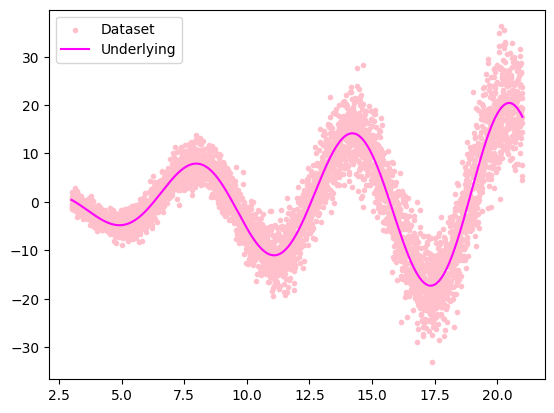

In [48]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 21
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax, 0.01).reshape(-1, 1)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5000, 1)
(1800, 1)
(5000, 1)


In [66]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_estimators=100, max_depth=3, dropout=0.1, random_state=42):
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.dropout = dropout
        self.random_state = random_state
        self.estimators = []
        self.seed = random_state

    def build_estimator(self, input_shape):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_estimators,
            max_depth=self.max_depth,
            dropout=self.dropout,  # Include dropout
            validation_ratio=0.1
        )
        return model

    def call(self, inputs, training=True):
        predictions = []
        for estimator in self.estimators:
            # Enable dropout during inference for uncertainty estimation
            predictions.append(estimator.predict(inputs, as_dict=True)['predictions'])
        predictions = tf.stack(predictions, axis=-1)
        mean_prediction = tf.reduce_mean(predictions, axis=-1)
        # Calculate standard deviation across ensemble predictions for uncertainty estimation
        variance_prediction = tf.math.reduce_std(predictions, axis=-1)
        return mean_prediction, variance_prediction

    def fit(self, X, y):
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = seed
            model = self.build_estimator(X.shape)
            model.fit(x=X, y=y)
            self.estimators.append(model)

    def predict(self, X):
        predictions = []
        for model in self.estimators:
            predictions.append(model.predict(X))
        predictions = np.array(predictions)
        mean_prediction = np.mean(predictions, axis=0)
        variance_prediction = np.var(predictions, axis=0)
        return mean_prediction, variance_prediction



In [67]:
gbt_model = GradientBoostedTreesEnsembleRegressor(n_estimators=50, max_depth=3, dropout=0.1)



In [ ]:
for i in range(100):  # Train 100 GBT models
    gbt_model = GradientBoostedTreesEnsembleRegressor(random_seed=i)  # Set a different random seed for each model
    ensemble.estimators.append(gbt_model)
    gbt_model.fit(X_train, y_train)

In [68]:
gbt_model.fit(X_train, y_train)

TypeError: GradientBoostedTreesModel.__init__() got an unexpected keyword argument 'dropout'

In [53]:
y_pred, uncertainties = gbt_model.predict(X_test)

57/57 [==============================] - 0s 393us/step


In [60]:
print(y_pred.shape)
print(uncertainties.flatten()[:50])

(1800, 1)
[7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15
 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15 7.993606e-15]


ValueError: 'y1' is not 1-dimensional

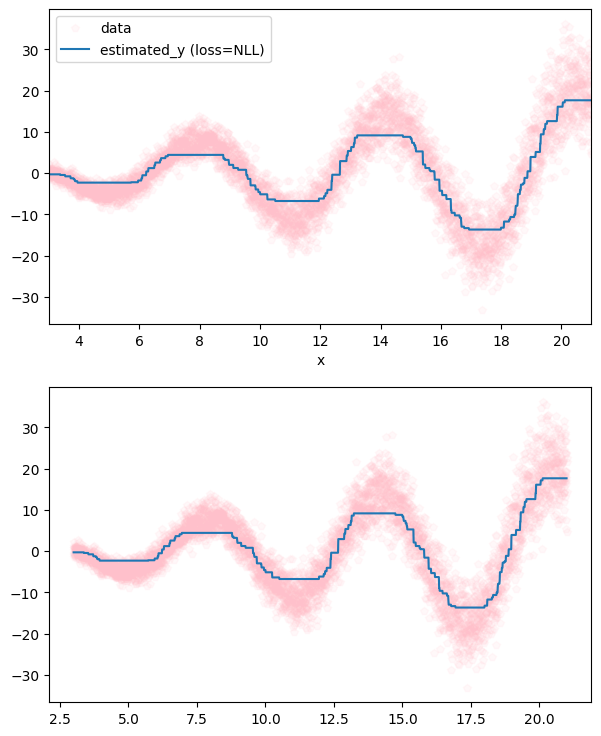

In [58]:
xlim = (xMin,xMax)
X_test = X_test.flatten()

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(X_test,y_pred,label="estimated_y (loss=NLL)")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
ax.plot(X_test,y_pred,label="estimated_y (loss=NLL)")
ax.fill_between(X_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.4, label="variance")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()